In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the cleaned dataset
data = pd.read_csv('Processed_Telecom_Churn.csv')

# Display the first few rows to inspect the data
data.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,tenure_days
0,2,0,25,10,4,155514,4,124962,44.0,45.0,5112.0,0,1879
1,2,0,55,16,5,6141,2,130556,62.0,39.0,5973.0,0,1879
2,3,0,57,1,2,77059,0,148828,49.0,24.0,193.0,1,1879
3,1,1,46,22,4,100632,1,38722,80.0,25.0,9377.0,1,1879
4,1,0,26,24,2,151894,2,55098,78.0,15.0,1393.0,0,1879


In [3]:
X = data.drop(columns=['churn'])
y = data['churn']
X.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,tenure_days
0,2,0,25,10,4,155514,4,124962,44.0,45.0,5112.0,1879
1,2,0,55,16,5,6141,2,130556,62.0,39.0,5973.0,1879
2,3,0,57,1,2,77059,0,148828,49.0,24.0,193.0,1879
3,1,1,46,22,4,100632,1,38722,80.0,25.0,9377.0,1879
4,1,0,26,24,2,151894,2,55098,78.0,15.0,1393.0,1879


In [4]:
from sklearn.feature_selection import mutual_info_classif
# Calculate MI Scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create DataFrame for MI Scores
mi_data = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_data.sort_values(by='MI Score', ascending=False, inplace=True)

# Display feature importance
print("Mutual Information Scores:")
print(mi_data)


Mutual Information Scores:
             Feature  MI Score
1             gender  0.034000
0    telecom_partner  0.008496
6     num_dependents  0.007420
4               city  0.007142
3              state  0.001827
10         data_used  0.001299
11       tenure_days  0.001246
9           sms_sent  0.000604
8         calls_made  0.000206
2                age  0.000000
5            pincode  0.000000
7   estimated_salary  0.000000


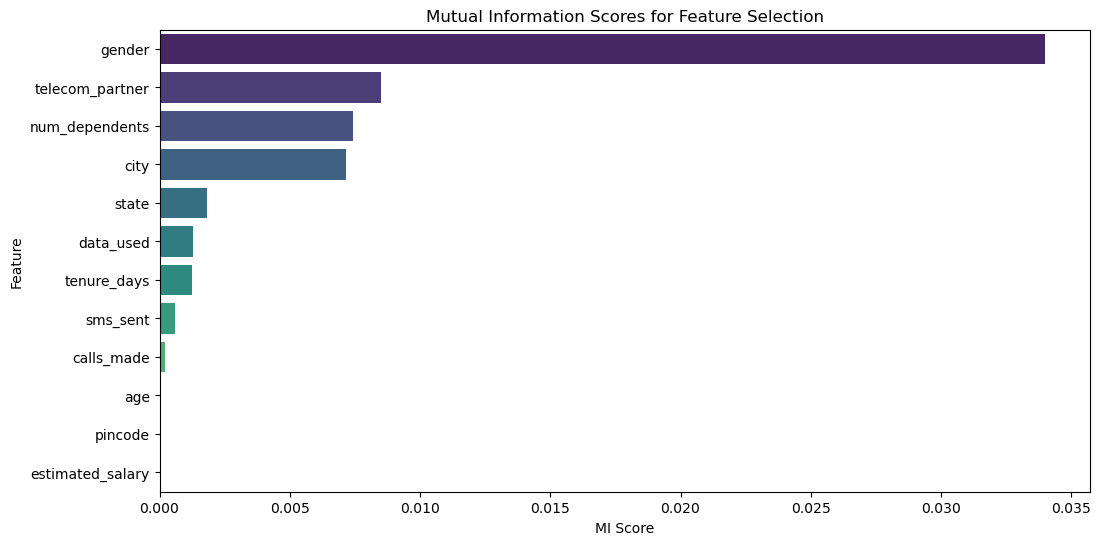

In [5]:
# Visualize MI Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_data, palette='viridis')
plt.title('Mutual Information Scores for Feature Selection')
plt.show()

In [6]:
# Select Features with MI Score > 0
selected_features = mi_data[mi_data['MI Score'] > 0]['Feature'].tolist()
X = X[selected_features]

print("Selected Features:", selected_features)

Selected Features: ['gender', 'telecom_partner', 'num_dependents', 'city', 'state', 'data_used', 'tenure_days', 'sms_sent', 'calls_made']


In [7]:
# SMOTEENN for oversampling the minority class
st = SMOTEENN(random_state=42, n_jobs=-1)
X_train_resampled, y_train_resampled = st.fit_resample(X, y)
print("The number of classes before fit:", Counter(y))
print("The number of classes after fit:", Counter(y_train_resampled))

The number of classes before fit: Counter({0: 194726, 1: 48827})
The number of classes after fit: Counter({1: 149003, 0: 78304})


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X_train_resampled)

minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X_train_resampled)

robust_scaler = RobustScaler()
X_scaled = robust_scaler.fit_transform(X_train_resampled)

In [9]:
# Perform stratified train-test split to maintain the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [10]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (181845, 9)
X_test shape: (45462, 9)


In [11]:
#List to store models
models = []

In [12]:
# Function to print the evaluation metrics
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)    
    y_probabilities = model.predict_proba(X_test)[:, 1]
    
    print('Precision: ', precision_score(y_test, y_pred_model))
    print('Recall: ', recall_score(y_test, y_pred_model))
    print('F1 Score: ', f1_score(y_test, y_pred_model))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_probabilities))
    
    plt.figure(figsize=(12,6))
    
    # Confusion matrix
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, fmt="d", annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    # ROC AUC Score
    model_roc_auc = roc_auc_score(y_test, y_probabilities) 
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
    
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC : %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.show()

Precision:  0.6918813089577666
Recall:  0.9130901647595718
F1 Score:  0.7872414291913786
ROC AUC Score:  0.660547399553149


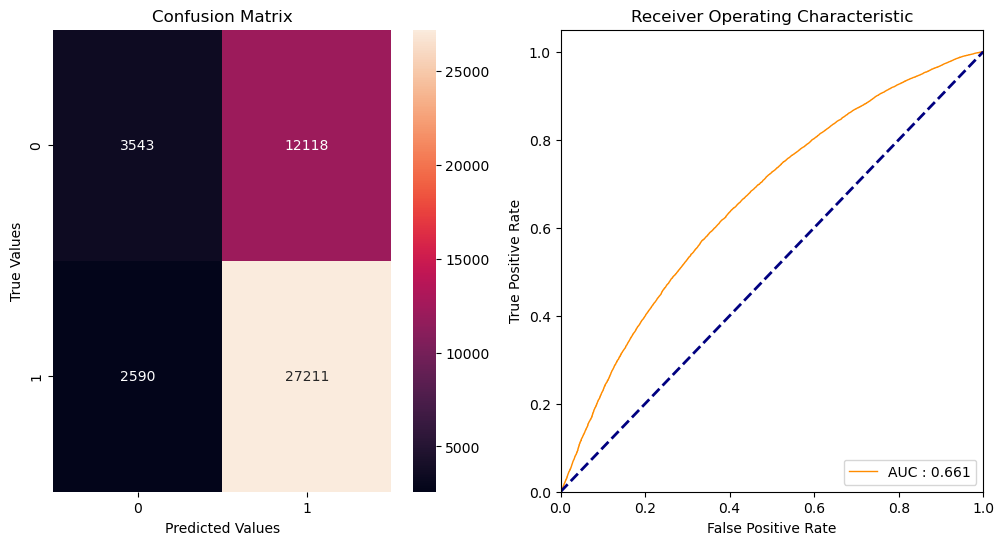

In [13]:
# Initialize and fit different models
# 1. Logistic Regression
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
models.append(churn_lr)
eval_metrics(churn_lr, X_test, y_test)

Precision:  0.8218665075893153
Recall:  0.8321532834468642
F1 Score:  0.8269779074614423
ROC AUC Score:  0.7444720187747059


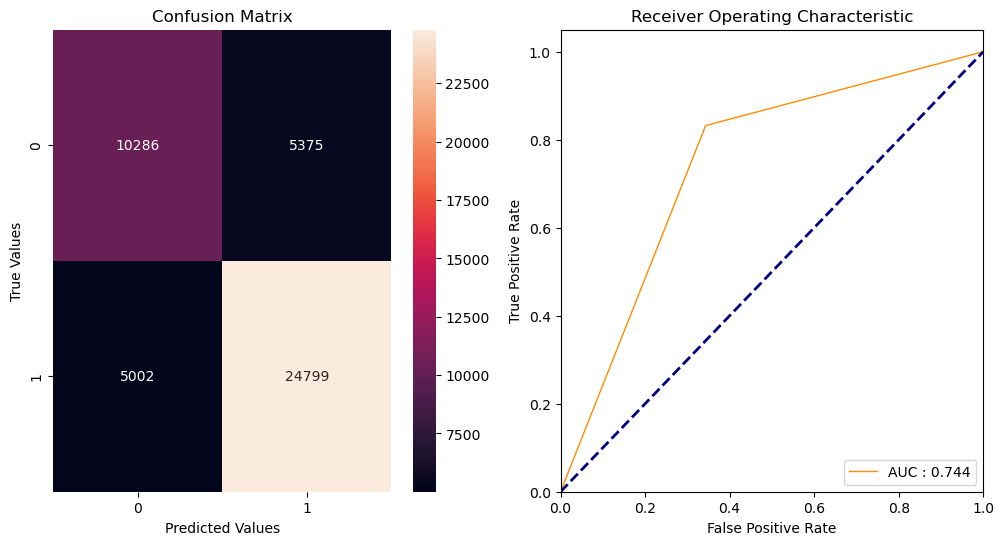

In [14]:
# 2. DecisionTreeClassifier
churn_DT = DecisionTreeClassifier(random_state=42)
churn_DT.fit(X_train, y_train)
models.append(churn_DT)
eval_metrics(churn_DT, X_test, y_test)

Precision:  0.7176293751342065
Recall:  0.8971511023120029
F1 Score:  0.7974111576718315
ROC AUC Score:  0.7189135669690916


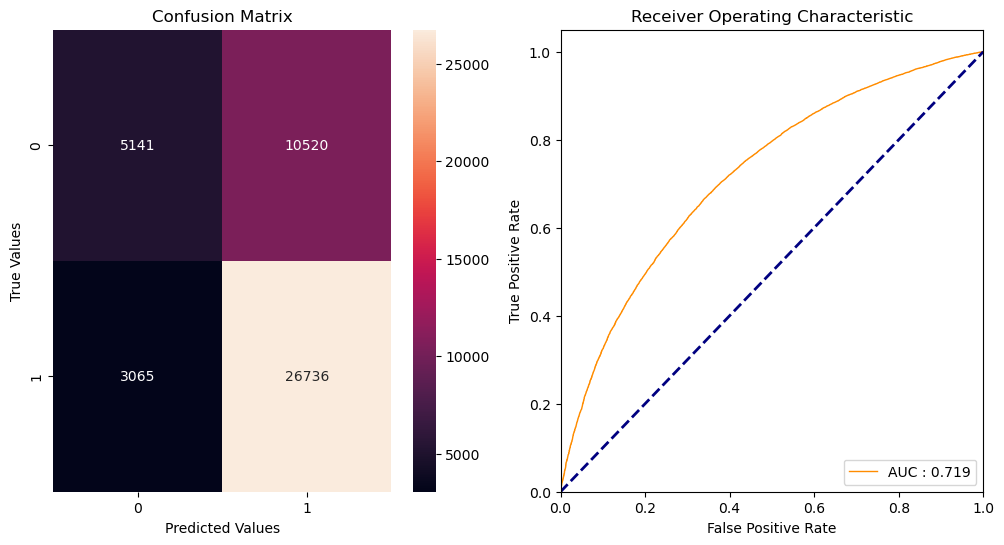

In [15]:
# 3. Gaussian Naive Bayes
churn_GNB = GaussianNB()
churn_GNB.fit(X_train, y_train)
models.append(churn_GNB)
eval_metrics(churn_GNB, X_test, y_test)

Precision:  0.7968884251871855
Recall:  0.871413710949297
F1 Score:  0.8324864960169261
ROC AUC Score:  0.8490412075344019


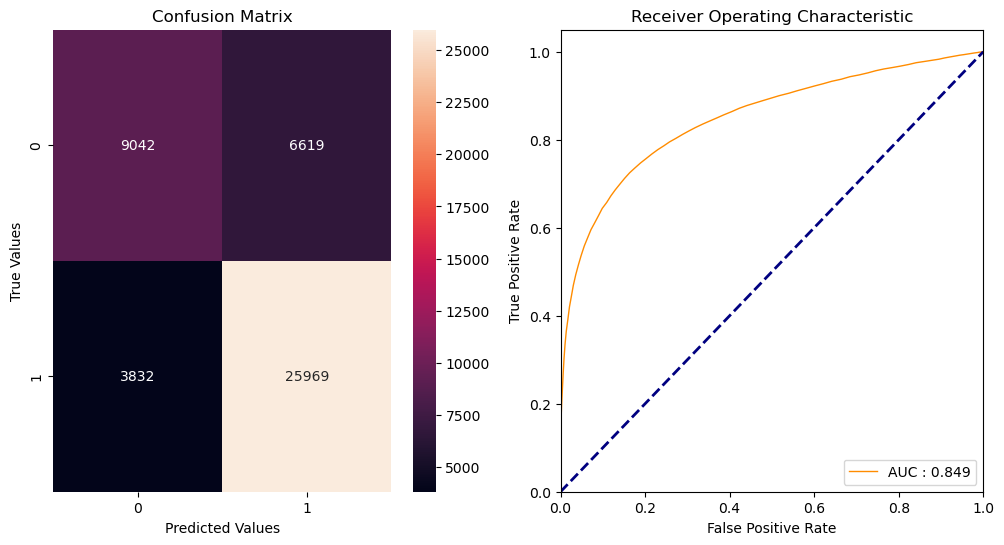

In [16]:
# 4. Random Forest
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
churn_rf.fit(X_train, y_train)
models.append(churn_rf)
eval_metrics(churn_rf, X_test, y_test)

Precision:  0.752086623054365
Recall:  0.895003523371699
F1 Score:  0.8173446717229755
ROC AUC Score:  0.8068588008863966


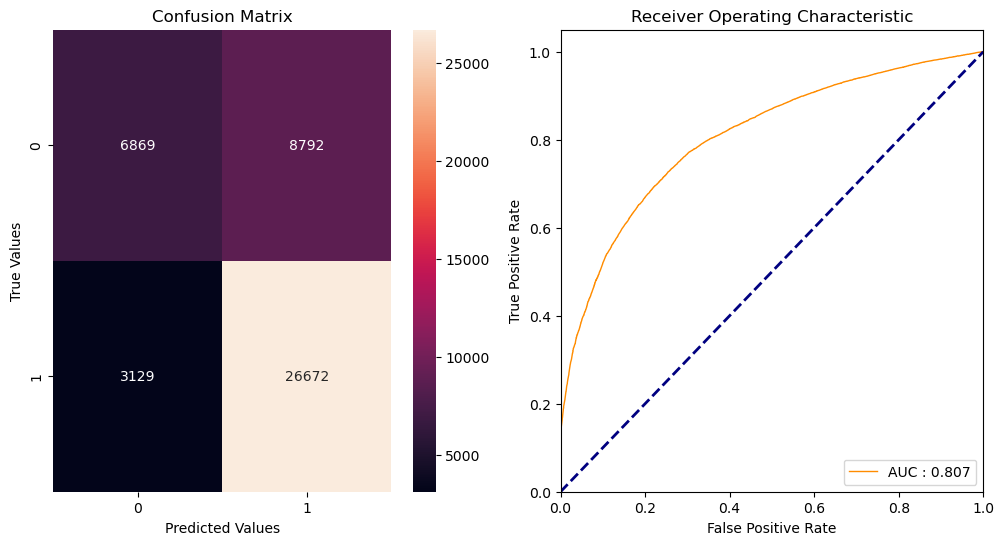

In [17]:
# 5. Gradient Boosting
churn_gb = GradientBoostingClassifier(random_state=42)
churn_gb.fit(X_train, y_train)
models.append(churn_gb)
eval_metrics(churn_gb, X_test, y_test)

Precision:  0.8591021562389537
Recall:  0.8155431025804504
F1 Score:  0.8367561240123255
ROC AUC Score:  0.8771182667902524


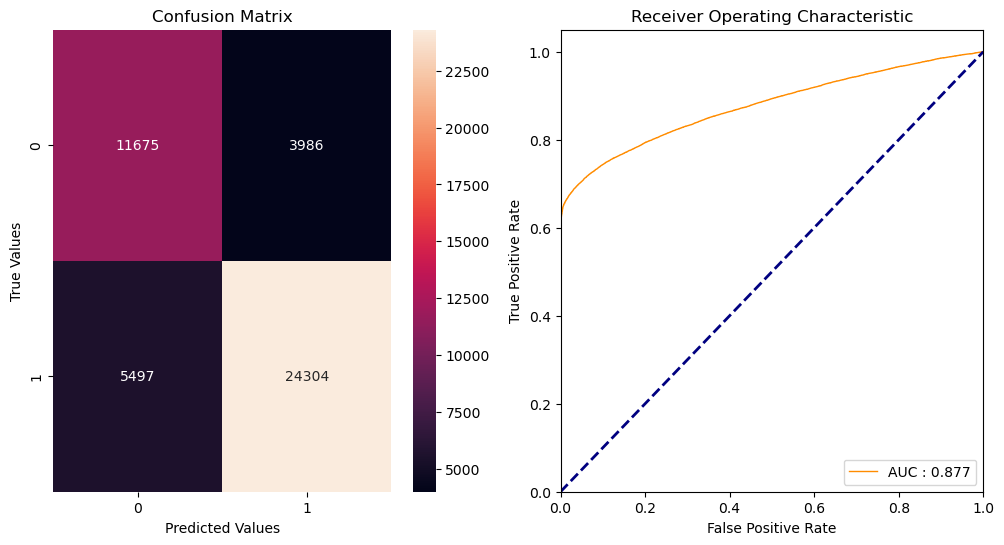

In [18]:
#6. XGBoost
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42)
churn_xgb.fit(X_train, y_train)
models.append(churn_xgb)
eval_metrics(churn_xgb, X_test, y_test)

In [19]:
from sklearn.model_selection import StratifiedKFold
# Model Comparison using K-Fold Cross Validation
result_col = ["Algorithm", "AUC Mean", "Bal Acc Mean", "Recall", "F1"]
model_results = pd.DataFrame(columns=result_col)

i = 0
for model in models:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_acc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="balanced_accuracy", n_jobs=-1)
    cv_auc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="roc_auc", n_jobs=-1)
    cv_recall_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="recall", n_jobs=-1)
    cv_f1_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="f1", n_jobs=-1)


    model_results.loc[i] = [model.__class__.__name__,
                                    round(cv_auc_results.mean() * 100, 2),
                                    round(cv_acc_results.mean() * 100, 2),
                                    round(cv_recall_results.mean() * 100, 2),
                                    round(cv_f1_results.mean() * 100, 2)
                           ]
    i += 1

model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)
print(model_results)

                    Algorithm  AUC Mean  Bal Acc Mean  Recall     F1
5               XGBClassifier     87.31         76.97   82.15  83.41
3      RandomForestClassifier     82.82         70.76   86.52  82.33
4  GradientBoostingClassifier     79.96         66.30   89.35  81.53
1      DecisionTreeClassifier     72.95         72.95   82.31  81.72
2                  GaussianNB     71.77         61.16   89.79  79.72
0          LogisticRegression     66.13         56.83   91.35  78.69


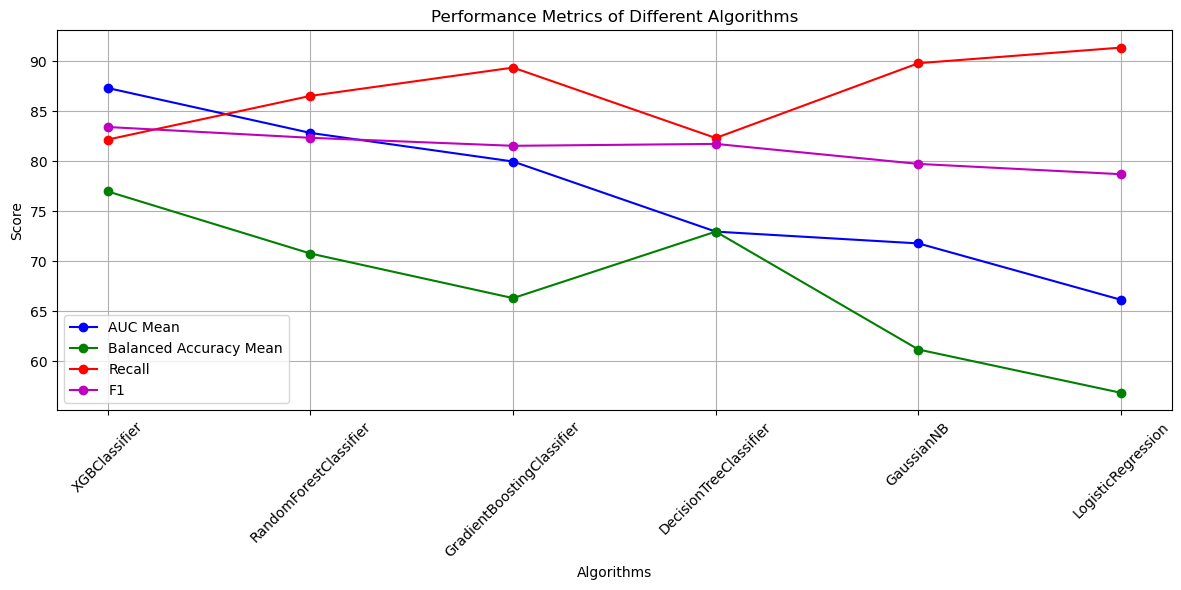

In [20]:
# Sort results by AUC score
model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)

# Plot model performance
plt.figure(figsize=(12, 6))
plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r'),
plt.plot(model_results['Algorithm'], model_results['F1'], marker='o', label='F1', color='m')

plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Define hyperparameter search space
rf_params_dist = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'max_features': ['sqrt', 'log2', None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'class_weight': ['balanced'],  
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize base model
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(
    churn_rf, 
    rf_params_dist, 
    n_iter=10,
    scoring='roc_auc', 
    cv=skf, 
    verbose=2,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get best parameters
best_params = rf_random.best_params_
print("Best Parameters for RF:", best_params)
print("Best Score for RF:", rf_random.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'ccp_alpha': 0.0}
Best Score for RF: 0.8257259827226084


In [22]:
# Train the optimized model
churn_rf_optimal = RandomForestClassifier(
                                           n_estimators=best_params['n_estimators'],
                                           max_depth=best_params['max_depth'],
                                           max_features=best_params['max_features'],
                                           min_samples_split=best_params['min_samples_split'],
                                           min_samples_leaf=best_params['min_samples_leaf'],
                                           class_weight=best_params['class_weight'],
                                           ccp_alpha=best_params['ccp_alpha'],
                                           random_state=42,
                                           n_jobs=-1
                                          )

# Fit the model on training data
churn_rf_optimal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)

Random Forest Model Evaluation:
Precision:  0.8096317099636178
Recall:  0.8512801583839469
F1 Score:  0.8299337531692157
ROC AUC Score:  0.8430689681778858


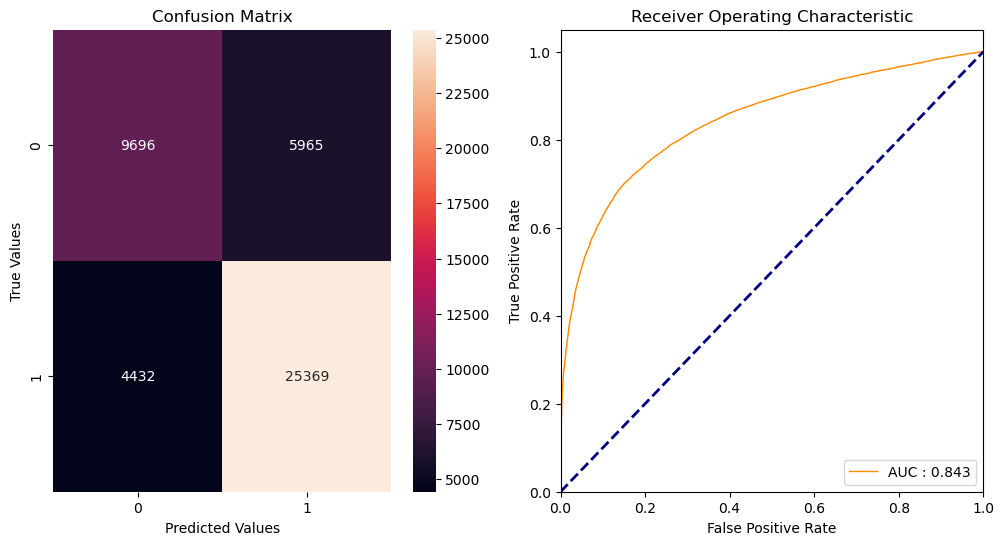

In [23]:
# Evaluate performance
print("Random Forest Model Evaluation:")
eval_metrics(churn_rf_optimal, X_test, y_test)

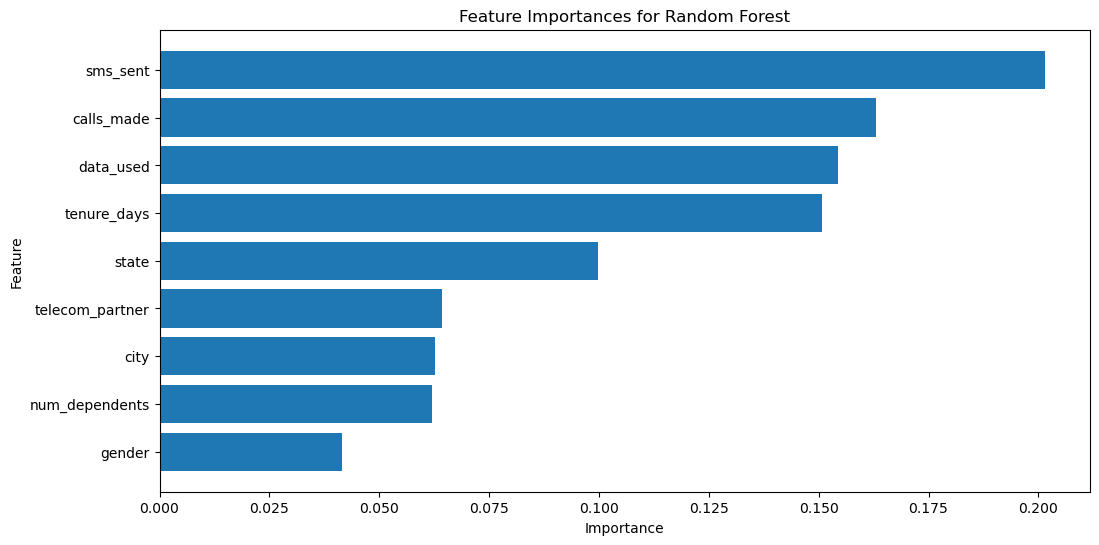

In [24]:
# Feature importance visualization for Random Forest
importances = churn_rf_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

In [25]:
# Define hyperparameter search space
xgb_params_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 6, 10],  
    'gamma': [0, 0.1, 0.5], 
    'reg_lambda': [1, 5, 10],  
    'scale_pos_weight': [1, 10, 25],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize base model
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)

# Perform Randomized Search
xgb_random = RandomizedSearchCV(
    churn_xgb,
    xgb_params_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=10,  # Randomly search 10 combinations
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get best parameters
best_params = xgb_random.best_params_
print("Best Parameters for XGBoost:", best_params)
print("Best Score for XGBoost:", xgb_random.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for XGBoost: {'subsample': 0.6, 'scale_pos_weight': 10, 'reg_lambda': 5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best Score for XGBoost: 0.885874601772171


In [26]:
# Train the optimized model
churn_xgb_optimal = xgb.XGBClassifier(objective='binary:logistic',
                                  n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  gamma=best_params['gamma'],
                                  reg_lambda=best_params['reg_lambda'],
                                  scale_pos_weight=best_params['scale_pos_weight'],
                                  subsample=best_params['subsample'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  seed=42,
                                  n_jobs=-1
                                 )

# Fit the model on training data
churn_xgb_optimal.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost Model Evaluation:
Precision:  0.6993808869938088
Recall:  0.9741954967954095
F1 Score:  0.8142248148979133
ROC AUC Score:  0.8942527693667699


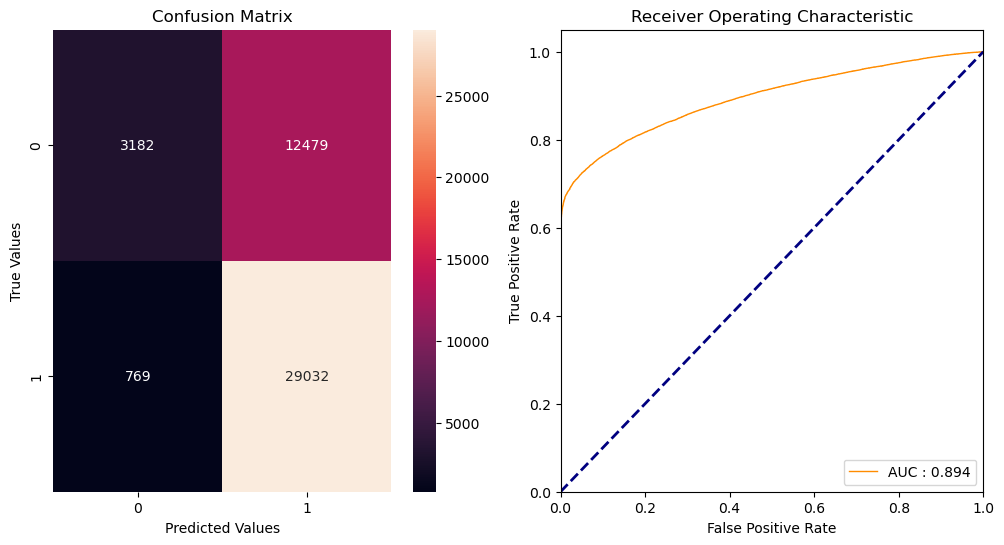

In [27]:
# Evaluate performance
print("XGBoost Model Evaluation:")
eval_metrics(churn_xgb_optimal, X_test, y_test)

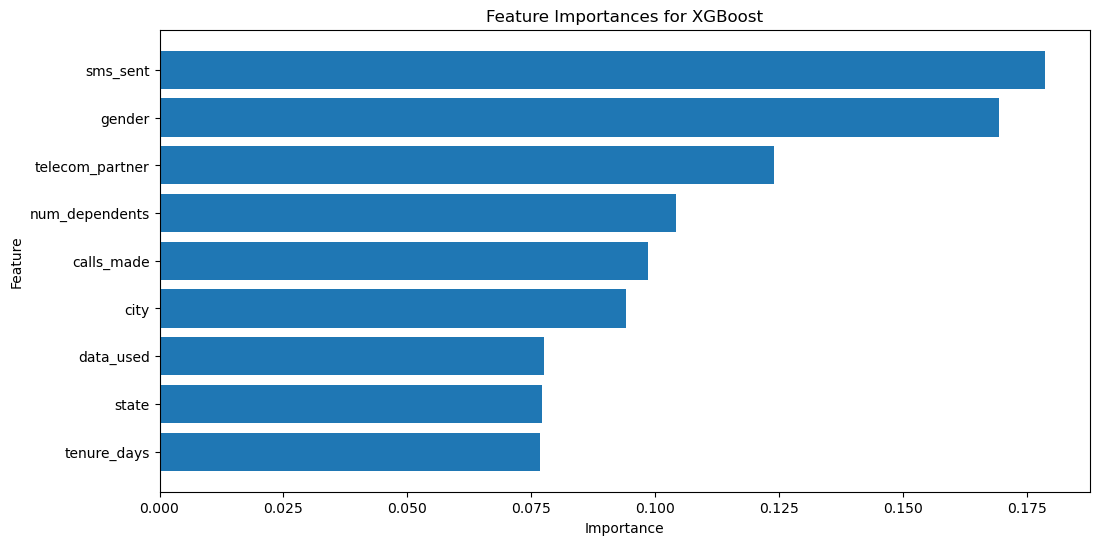

In [28]:
# Feature importance visualization for XGBoost
importances = churn_xgb_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.show()

In [29]:
import pickle

# Save the final XGBoost model to disk
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl', 'wb'))

In [30]:
# Save the final XGBoost model to disk
pickle.dump(churn_rf_optimal, open('churn_rf_optimal.pkl', 'wb'))